In [0]:
from typing import List, Tuple
import pandas as pd
import requests
from io import StringIO
import re
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns


def download_stats():
    f1 = "https://www.stat.gouv.qc.ca/statistiques/population-demographie/deces-mortalite/DecesSemaine_QC_2010-2020_Sexe.csv"

    req = requests.get(f1)
    csv = req.text
    df = pd.read_table(StringIO(csv), skiprows=5, sep=";", thousands=" ")

    # Remove comment line #1 and comments at end of file
    df = df[1:33]

    df.iloc[:,3:] = df.iloc[:,3:].replace(" ", "", regex=True).astype(float)
    # df = df.set_index(df.columns[0])
    df = df.drop("Statut", 1)

    return df

In [0]:
# Population stats de https://www.stat.gouv.qc.ca/statistiques/population-demographie

population = pd.DataFrame([7929222, 8005090, 8061101, 8110880, 8150183, 8175272, 8225950, 8298827, 8387632, 8484965],
                          index=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
current_population = 8484965
# population

In [0]:
def get_grouping_by_sex(sexe):
    df = download_stats()
    g = df[df.Sexe == sexe]
    g = g.transpose()
    g.drop("Sexe", inplace=True)
    g.columns = g.iloc[0]
    g = g[1:53]
    return g
# hommes = df[df.Sexe == "Hommes"].drop(df.columns[0], axis=1)
# femmes = df[df.Sexe == "Femmes"].drop(df.columns[0], axis=1)

In [0]:
total = get_grouping_by_sex("Total")
# total.plot()

In [0]:
def add_rolling_mean(df, col_name, new_col_name, window):
    df[new_col_name] = df.loc[:, col_name].rolling(window=window).mean()
    # df[new_col_name] = df[new_col_name].shift(-window // 2)

def add_mean(df, col_name, new_col_name):
    df[new_col_name] = df.loc[:, col_name].mean()

def add_constant(df, new_col_name, value):
    df[new_col_name] = value

def create_df(values, mean_type="rolling", rolling_window=52):
    s = []
    w = []
    d = []

    for i in range(2010, 2020+1):
        yd = values[f"{i}"].array
        s.extend([f"{i}"] + [f"{x}" if (x % 13==0) and x<52 else "" for x in range(1, len(yd))])
        w.extend([f"{i}-{w+1:02}" for w in range(len(yd))])
        d.extend(yd)

    df = pd.DataFrame({"semaine_label" : s, "week_code" : w, "deces" : d})

    for i in range(2010, 2020):
        df.loc[df.week_code == f"{i}-01", "population"] = population.iloc[i-2010].item()
    df.loc[df.week_code == "2020-52", "population"] = population.iloc[-1].item()
    
    # Add normalized population column
    df["population"] = df["population"].interpolate()
    df["deces_norm"] = df.deces * current_population / df["population"]

    # add mean column
    if mean_type == "rolling":
        add_rolling_mean(df, "deces", "av", rolling_window)
        add_rolling_mean(df, "deces_norm", "av_norm", rolling_window)
    elif mean_type == "global":
        add_mean(df, "deces", "av")
        add_mean(df, "deces_norm", "av_norm")

    # Extend the missing, up to the season limit
    value = df.loc[rolling_window-1, "av"].item()
    value_norm = df.loc[rolling_window-1, "av_norm"].item()
    df.loc[:rolling_window, "av"] = value
    df.loc[:rolling_window, "av_norm"] = value_norm

    # Diff 
    df["diff_deces"] = (df["deces"] - df["av"]).clip(lower=0)
    df["diff_deces_norm"] = (df["deces_norm"] - df["av_norm"]).clip(lower=0)

    return df

In [0]:

df = create_df(total, mean_type="rolling", rolling_window=52 * 2)
df

,semaine_label,week_code,deces,population,deces_norm,av,av_norm,diff_deces,diff_deces_norm
0,2010,2010-01,1217.0,7929222.0,1302.297048,1134.711538,1203.64111,82.288462,98.655938
1,,2010-02,1197.0,7930681.0,1280.659644,1134.711538,1203.64111,62.288462,77.018534
2,,2010-03,1163.0,7932140.0,1244.054479,1134.711538,1203.64111,28.288462,40.413369
3,,2010-04,1135.0,7933599.0,1213.879763,1134.711538,1203.64111,0.288462,10.238653
4,,2010-05,1194.0,7935058.0,1276.745326,1134.711538,1203.64111,59.288462,73.104216
...,...,...,...,...,...,...,...,...,...
567,,2020-48,NaN,8484965.0,NaN,NaN,NaN,NaN,NaN
568,,2020-49,NaN,8484965.0,NaN,NaN,NaN,NaN,NaN
569,,2020-50,NaN,8484965.0,NaN,NaN,NaN,NaN,NaN
570,,2020-51,NaN,8484965.0,NaN,NaN,NaN,NaN,NaN


In [0]:
def integrate_seasons(df, col):

    season_totals = {}
    
    for i in range(2011, 2020+1):
        left = f"{i-1}-44"
        right = f"{i}-22"

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item()
        season_totals[i] = df.loc[i1:i2, col].sum()

    return season_totals

def integrate_year(df, col):

    season_totals = {}
    
    for i in range(2011, 2020):
        left = f"{i}-01"
        right = f"{i}-52"

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item()
        season_totals[i] = df.loc[i1:i2, col].sum()

    return season_totals

In [0]:
def draw_seasons(df, ax, col_deces, col_av52, col_diff_deces):
    for i in range(2011, 2020+1):
        left = f"{i-1}-44"
        right = f"{i}-22"

        plt.axvline(x=f"{i}-01", c="grey", alpha=0.10)
        plt.axvspan(xmin=left, xmax=right, color="tab:gray", alpha=0.1)

        i1 = df.index[df['week_code'] == left].item()
        i2 = df.index[df['week_code'] == right].item() + 1
        
        # Fill from 0 to average
        ax.fill_between(df["week_code"][i1:i2], 0, df[col_av52][i1:i2], 
                        facecolor='tab:blue', alpha=0.2)

        # Fill from average to top
        ax.fill_between(df["week_code"][i1:i2], df[col_av52][i1:i2], df[col_deces][i1:i2], 
                        where=df[col_diff_deces][i1:i2] > 0, facecolor='tab:red', alpha=0.2)
        
def draw_lineplot(values, col_deces, col_av, col_diff_deces, mean_type, rolling_window=52):
    df = create_df(values, mean_type, rolling_window)

    fig, ax = plt.subplots(figsize=(20, 8))
    plt.subplots_adjust(top=0.8)

    g = sns.lineplot(x="week_code", y=col_deces, data=df, label="Décès par semaine", color="tab:blue")
    sns.lineplot(x="week_code", y=col_av, data=df, label=f"Moyenne des {rolling_window} semaines précédentes", color="tab:orange")
    # sns.lineplot(x="week_code", y="deces", data=df, label="Décès par semaine.")
    # sns.lineplot(x="week_code", y="av", data=df, label="Moyenne sur 52 semaines")
    # sns.lineplot(x="week_code", y="diff_deces_norm", data=df, label="Diff. décès p/r moyenne, normalisé par population totale dans le temps.")

    g.set_xticklabels(df["semaine_label"])

    ax.set(xlabel="Semaines", ylabel="Decès", title="")

    draw_seasons(df, ax, col_deces, col_av, col_diff_deces)
    
    # Title
    plt.text(52*5, 2700, "Décès par semaine au Québec, $\\bf{toutes\ causes\ confondues}$", fontsize="xx-large", ha="center")

    # Totals whole year header
    plt.text(50, 600, "Total pour l'année:", fontsize="large", ha="right", color="grey")
    year_totals = integrate_year(df, col_deces)
    for i, v in enumerate(year_totals.values()):
        plt.text((i+1) * 52 + 26, 600, int(v), fontsize="large", ha="center", color="grey")
        plt.annotate("", xytext = ((i+1) * 52, 580), xy = ((i+1) * 52 + 52, 580), color="grey ", arrowprops = {"facecolor" : "grey", "arrowstyle": "<|-|>"})

    # Totals header
    plt.text(36, 2525, "Total par saison grippale:", fontsize="large", ha="right", color="tab:blue")
    season_totals = integrate_seasons(df, col_deces)
    for i, v in enumerate(season_totals.values()):
        plt.text((i+1) * 52 + 7, 2525, int(v), fontsize="large", ha="center", color="tab:blue")

    # Excess header
    plt.text(36, 2450, "Excès p/r à la moyenne:", fontsize="large", ha="right", color="tab:red")
    season_totals_diff_over_mean = integrate_seasons(df, col_diff_deces)
    for i, v in enumerate(season_totals_diff_over_mean.values()):
        plt.text((i+1) * 52 + 7, 2450, int(v), fontsize="large", ha="center", color="tab:red")

    # Lockdown date
    plt.axvline(x="2020-12", c="red", alpha=0.25)
    plt.annotate("Début du confinement au Québec (16 mars 2020)",
        ha = "center", va = "bottom",
        xytext = (52*8, 2200), xy = (52*10+12, 2100),
        arrowprops = {"facecolor" : "black", "arrowstyle": "-|>", "connectionstyle": "angle,angleA=0,angleB=-45,rad=10"})

    plt.annotate("1er janvier",
        ha = "center", va = "bottom",
        xytext = (52*7, 2050),xy = (52*8, 2000),
        arrowprops = {"facecolor" : "black", "arrowstyle": "-|>", "connectionstyle": "angle,angleA=0,angleB=-45,rad=10"})

    plt.annotate("", xytext = (52*7-10, 1800),xy = (52*7+22, 1800),arrowprops = {"facecolor" : "black", "arrowstyle": "<|-|>"})
    plt.text(52*7 + 7, 1850, "Saison\ngrippale", ha="center")


    plt.xticks(rotation=90)
    ax.set_ylim([400,2400])

    fig.text(0.90, 0.0, 'github.com/yanickc', fontsize=20, color='gray', ha='right', va='bottom', alpha=0.5)
    plt.show()

    fig.savefig("line_graph.png")

In [0]:
def draw_barplot(values):
    df = create_df(values)
    season_totals = integrate_seasons(df, col="deces_norm")

    st = pd.DataFrame({"annee":list(season_totals.keys()), "deces": list(season_totals.values())})
    st.columns = ["annee", "deces"]
    # st.index.name = "annee"
    # st = st.transpose()
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.subplots_adjust(top=0.8)

    g = sns.barplot(x="annee", y="deces", data=st, palette="Blues_d")
    
    for index, row in st.iterrows():
        g.text(x=row.name, y=(int(row.deces) * 0.95), s=int(row.deces), color='white', va="center", ha="center",fontsize="xx-large")


    plt.title("Décès au Québec $\\bf{toutes\ causes\ confondues}$\npar saison grippale\n[de novembre à mai (semaines CDC 44 à 22)]\n",
              fontsize="xx-large")

    fig.text(0.90, 0.0, 'github.com/yanickc', fontsize=20, color='gray', ha='right', va='bottom', alpha=0.5)
    plt.show()

    fig.savefig("bar_graph.png",pad_inches=0.5)

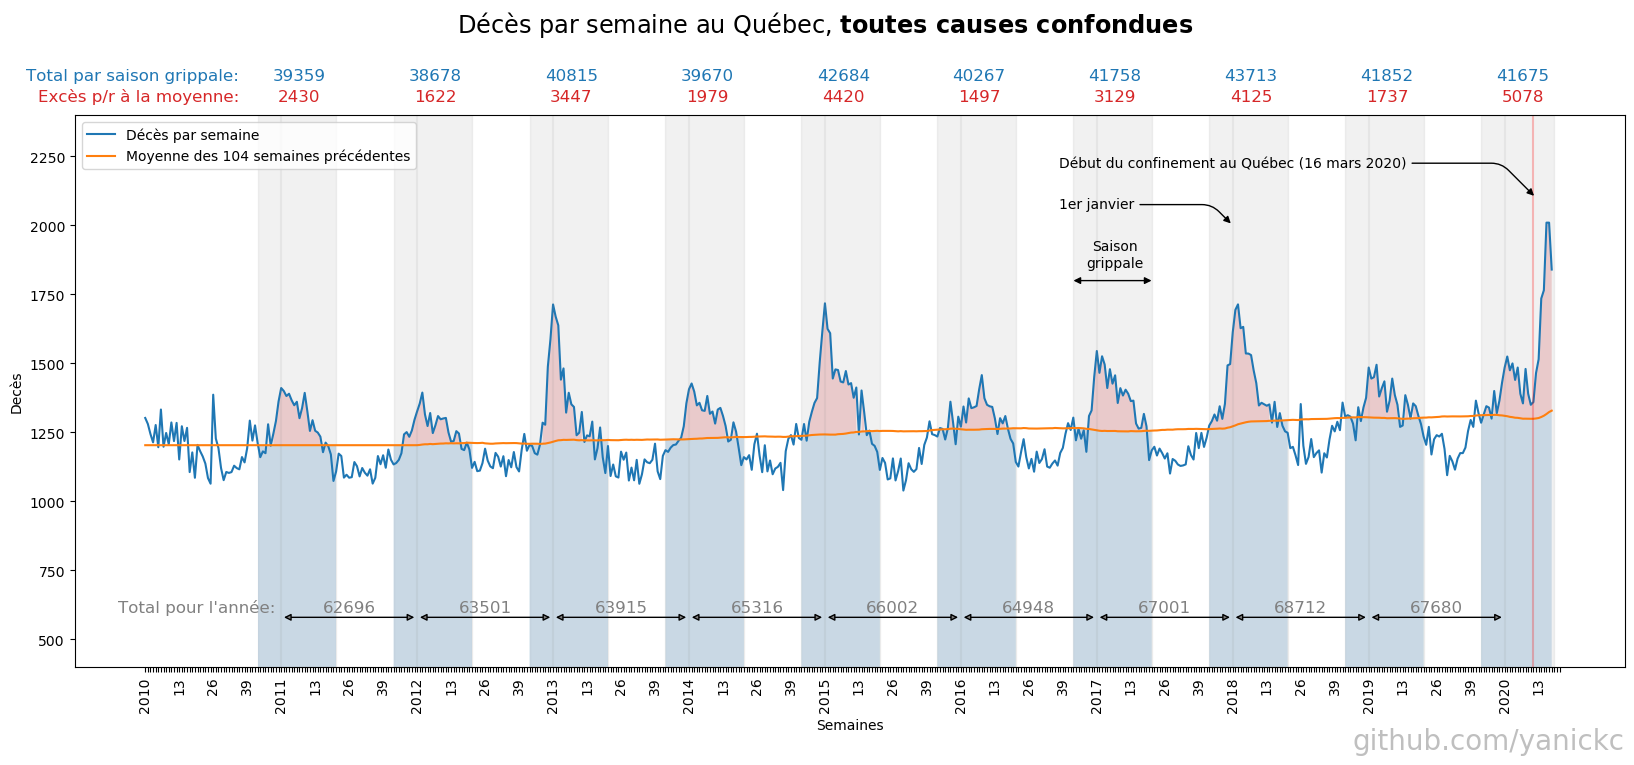

In [0]:
draw_lineplot(total, "deces_norm", "av_norm", "diff_deces_norm", mean_type="rolling", rolling_window=52*2)

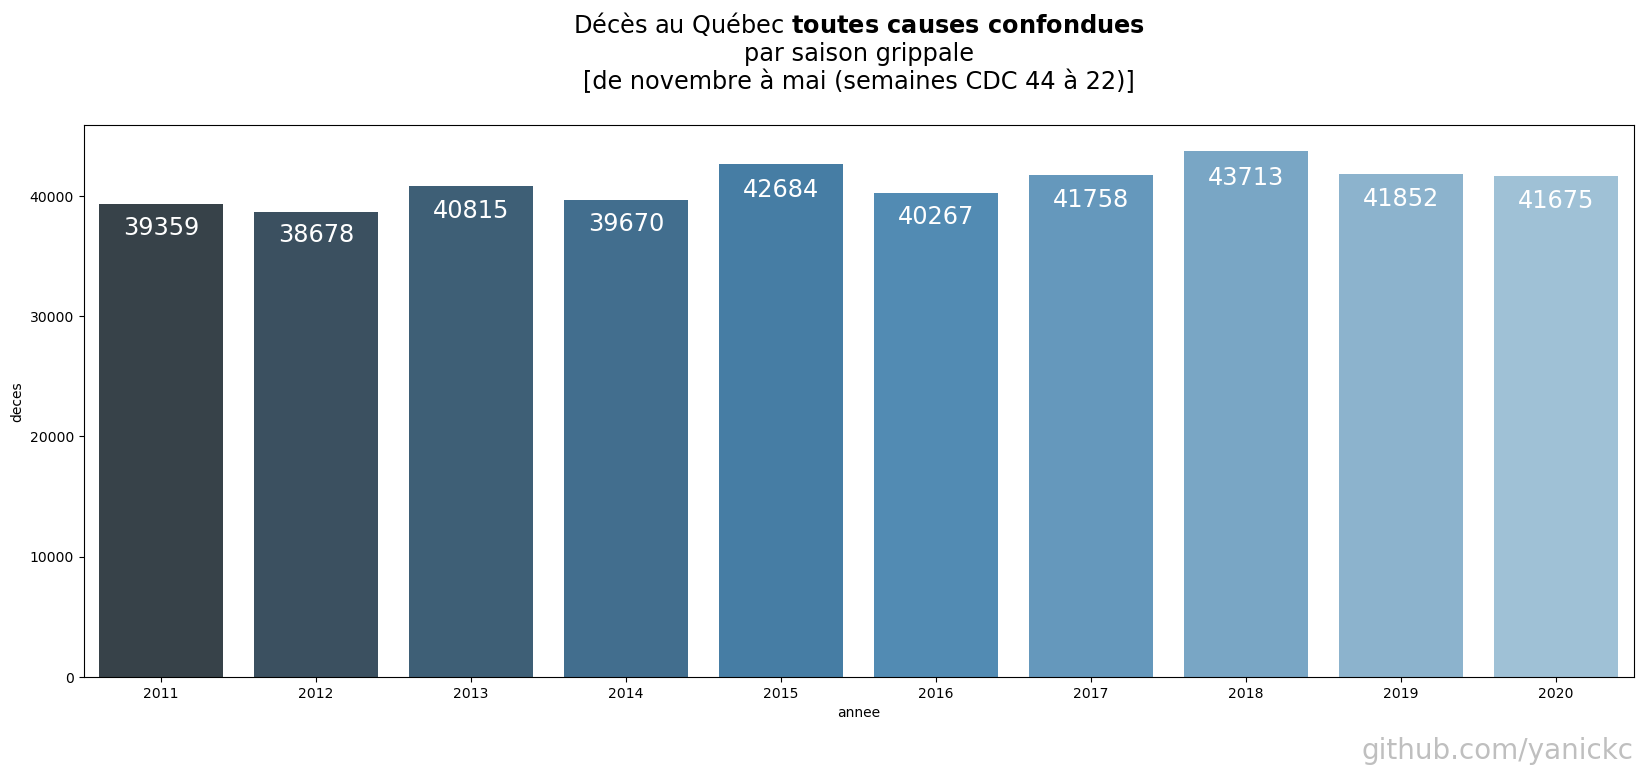

In [0]:
draw_barplot(total)